# Deep Neural Network Project - CST-435

- Owen Kroeger
- Teddy Coon


**Project Overview:** This project addresses the challenge of developing a robust and accurate deep learning model for image classification tasks. We built a complex Convolutional Neural Network, a type of deep learning model primarily used for analyzing visual data, which trained on 50,000 Google Street View images to predict the country of origin of a specific image. Specifically, we explore two interesting models—EfficientNet and ResNet—through transfer learning techniques to classify images. The task involves preprocessing, data augmentation, training, evaluation, and visualization of classification metrics and confusion matrices. The implementation adheres to assignment requirements by focusing on:

- **Transfer Learning:** This involves leveraging a model pre-trained on a large dataset (e.g.ImageNet) and adapting it to a smaller task-specific dataset. Pre-trained models already capture low-level features and higher-level representations useful for various image classification tasks.
- **Ensemble Methods for Prediction:** Ensemble learning combines predictions from multiple models to improve its accuracy and robustness. Each model brings its strenghts, and averaging their outputs helpts mitigate individual weaknesses. Each model outputs probabilities for each class, and these are then averaged, based on weights given to each model. A final prediction can then be made from this value.
- **Evaulation metrics** including classification reports and confusion matrices.
- **Visualization** of first 4 predictions for interpretability.


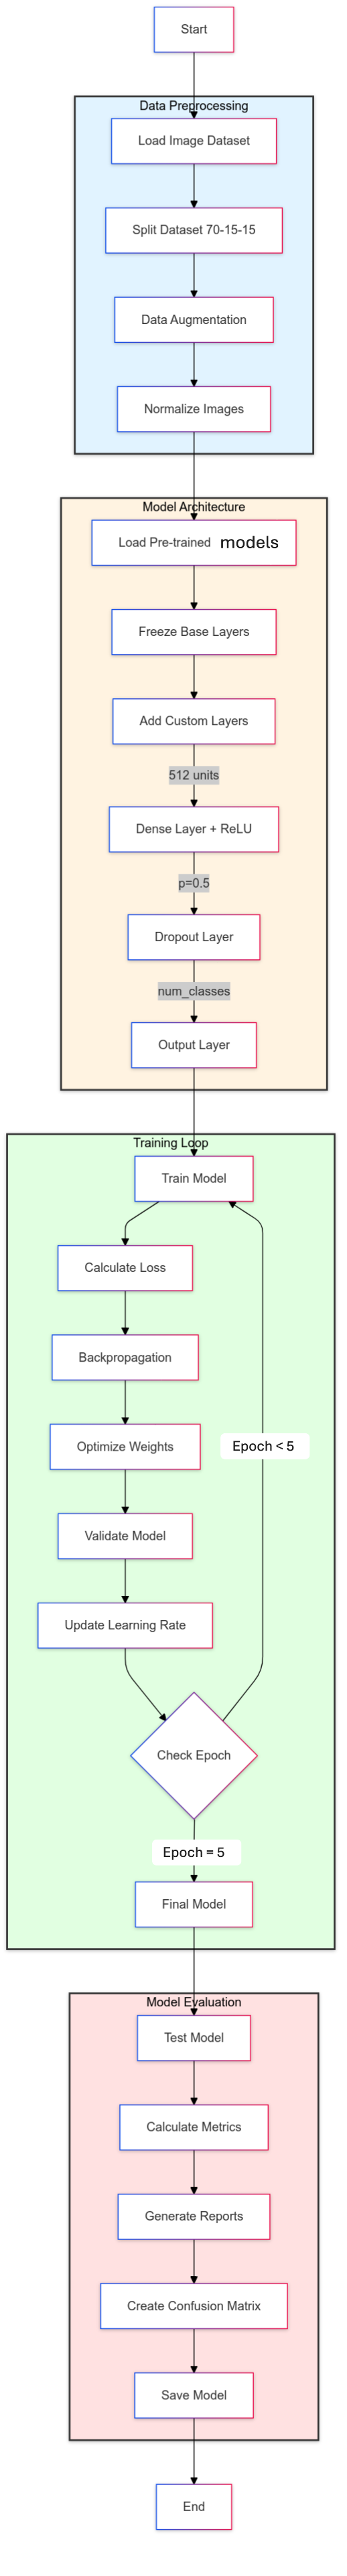

### Cell 1: Imports and Constants

1. **Import Libraries:**
This cell imports all necessary libraries for the project:

- Torch and torchvision for deep learning and image handling.
- tqdm for progress bars.
- matplotlib and seaborn for visualization.
- sklearn for evaluation metrics.

2. **Define Constants:**
Define key constants for reproducibility and configuration:

- DEVICE: Enables GPU usage if available.
- BATCH_SIZE, EPOCHS, LEARNING_RATE: Training hyperparameters.
- IMAGE_SIZE: Standardized input image dimensions.
- DATA_DIR: Path to the dataset.

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, efficientnet_b0
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from tqdm import tqdm
import pandas as pd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
IMAGE_SIZE = (128, 128)
DATA_DIR = "./dataset/compressed_dataset"

### Cell 2: Data Preparation

1. **Preprocessing and Augmentation:** The first part of this cell applies transofmrations for data preprocessing, including resizing, normalization, and augmentation.

2. **Dataset Loading and Splitting:**
The dataset is loaded, transformed, and split into training, validation, and test sets in a 70-15-15 ratio.

3. **Data Loaders:**
Create PyTroch DataLoaders for efficient data batching and shuffling.

In [2]:
# Data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes

# Split dataset into train, val, and test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

print("Splitting dataset...")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
print("Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

Splitting dataset...
Creating data loaders...


### Cell 3: Initialize ResNet18 (Transfer Learning)

These cells initialize ResNet18 for transfer learning, freezes layers except for the final ones, and customizes the classification head.

ResNet18 is pre-trained on the ImageNet dataset, meaning its lower layers capture generalized features like edges, textures, and patterns. These are broadly applicable to various datasets and are left frozen to retain their utility.

All pre-trained layers were frozen, which avoids overwriting learned features, focusing training on the newly added layers.

Custom Classification Head:

- **Linear:** Reduces dimensionality for feature extraction.
- **ReLU:** Introduces non-linearity.
- **Dropout:** Reduces overfitting by randomly deactivating neurons during training.
- Final **Linear** layer: Matches the number of classes in the dataset.

*CrossEntropyLoss* computes the difference between predicted and true class distributions.

Adam optimizer is configured to update only the classification head (fc) with a learning rate of 0.001.

In [3]:
print("Initializing ResNet18...")
model_resnet18 = resnet18(weights="IMAGENET1K_V1")
for param in model_resnet18.parameters():
    param.requires_grad = False  # Freeze all layers

# Replace the final layer
model_resnet18.fc = nn.Sequential(
    nn.Linear(model_resnet18.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, len(class_names))
)
model_resnet18 = model_resnet18.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer_resnet18 = torch.optim.Adam(model_resnet18.fc.parameters(), lr=LEARNING_RATE)

Initializing ResNet18...


### Cell 4: Fine-Tune ResNet18

*layer4* (last block) was unfrozen and the classification head (fc) to adapt high-level features to the new dataset while keeping lower-level features unchanged.

The optimizer was updated to include parameters from unfrozen layers, and a reduced learning rate ensures stable updates without disrupting pre-trained weights.

In [4]:
# Unfreeze specific layers
for name, param in model_resnet18.named_parameters():
    if "layer4" in name or "fc" in name:  # Fine-tune the last block and fully connected layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Update optimizer for fine-tuning
optimizer_finetune_resnet18 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_resnet18.parameters()), lr=1e-4
)

### Cell 5: Initialize EfficientNet

EfficientNet-B0, a compact and efficient architecture pre-trained on ImageNet, was initialized. The final classification layer (*classifier[1]*) was replaced with a custom layer for dataset-specific classification.

In [5]:
print("Initializing EfficientNet_B0...")
model_effnet = efficientnet_b0(weights="IMAGENET1K_V1")
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, len(class_names))
model_effnet = model_effnet.to(DEVICE)

optimizer_effnet = torch.optim.Adam(model_effnet.parameters(), lr=LEARNING_RATE)

Initializing EfficientNet_B0...


### Cell 6: Training and Validation Functions

- Defines the training loop for weight updates and the validation loop to evaluate model performance on unseen data.
- Tracks loss and accuracy for monitoring progress.

In [6]:
# Training function
def train_one_epoch(epoch, model, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{EPOCHS}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix(Loss=running_loss / total, Accuracy=100 * correct / total)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / len(train_loader.dataset)
    return epoch_loss, epoch_acc

# Validation function
def validate(model):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100 * correct / len(val_loader.dataset)
    return val_loss, val_acc

### Cell 7: Ensemble Prediction

Combines predictiosn from both ResNet18 and EfficientNet using an average of their softmax outputs, creating a stronger classifier.

In [7]:
def ensemble_predict(models, inputs):
    outputs = [torch.softmax(model(inputs), dim=1) for model in models]
    ensemble_output = sum(outputs) / len(models)  # Average predictions
    return torch.argmax(ensemble_output, dim=1)

### Cell 8: Test Function

The test function evaluates the model on the test dataset, displaying:

- First-4 predictions with probabilites for interpretability.
- Classification report with precision, recall, and F-1 scores.
- Confusion matrix highlighting prediction patterns.

In [8]:
# Test function with top-4 predictions and visualization of top-10 most accurate classes
def test(model, top_k_most_accurate=10):
    print("Testing model...")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="Testing")):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)

            # Get top-4 predictions
            probabilities = torch.softmax(outputs, dim=1)
            top4_prob, top4_indices = torch.topk(probabilities, 4, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(top4_indices[:, 0].cpu().numpy())  # Store top-1 prediction for metrics

            # Display the first 4 images and predictions from the first batch only
            if batch_idx == 0:
                for i in range(min(4, len(inputs))):
                    img = inputs[i].cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy image
                    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
                    img = img.clip(0, 1)  # Clip values to valid range

                    plt.figure(figsize=(5, 5))
                    plt.imshow(img)
                    plt.axis("off")
                    plt.title(f"Actual: {class_names[labels[i].item()]}", fontsize=14)
                    plt.show()

                    print("Predictions:")
                    for rank, (prob, idx) in enumerate(zip(top4_prob[i], top4_indices[i])):
                        print(f"  {rank + 1}: {class_names[idx.item()]} ({prob.item() * 100:.2f}%)")

    # Get unique labels present in predictions and ground truth
    unique_labels = sorted(set(y_true) | set(y_pred))
    filtered_class_names = [class_names[i] for i in unique_labels]  # Filtered class names

    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_class_names, zero_division=0))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Calculate accuracy per class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100  # Accuracy per class in percentage
    top_k_indices = class_accuracies.argsort()[-top_k_most_accurate:][::-1]  # Top-k most accurate classes

    # Filter confusion matrix for top-k classes
    filtered_cm = cm[top_k_indices][:, top_k_indices]
    filtered_labels = [filtered_class_names[i] for i in top_k_indices]

    # Plot confusion matrix for top-k most accurate classes
    plt.figure(figsize=(10, 8))
    sns.heatmap(filtered_cm, annot=True, fmt="d", xticklabels=filtered_labels, yticklabels=filtered_labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: Top-{top_k_most_accurate} Most Accurate Classes")
    plt.show()

### Cell 9: Training Loop and Model Testing

This cell trains both models over multiple epochs, tracking both the loss and accuracy. It then saves the trained models for future inference, and tests the models as well as displays the results and reports about performance metrics.

**Effectiveness:** Overall, EfficientNet way outperformed ResNet, reaching a 65% accuracy of guessing the country correctly vs ResNet's 30%. 

**Challenges:** Recognizing a country based on a street view images provides some unique and hard challenges for neural networks. For one, a country can look very different depending on where in that country the image was taken. That being said, many countries can look extremely similar or be completely indistinguishable from each other depending on the pictures. Also, streetview coverage is not always facing the road with clear signs as to where the image was taken. The image could be facing away from the road, looking at a field with no buildings or signs as to where in the world the location is. Larger countries (such as the USA) tend to have much more streetview compared to smaller countries, leading to heavy biases during training. Thus, if a small or rare country comes up in the test data, the model is much more likely to predict a larger country as there are more images that are close to that image despite the country being wrong.

**Conclusion:** Overall, the model exceeded expectations given the challenge of locating street view images by country. However, the first four predictions that were displayed for each model are somewhat unlucky. Despite the 30% and 65% accuracy scores for ResNet and EfficientNet (respectively), ResNet only gets one country right where as EfficientNet correctly guesses zero (in the first four), which does not show an accurate representation of the true accuracy scores that were reached by these models. If a different subsection of guesses were chosen to be displayed, it is likely that there exists many where each model guessed most, if not all, countries correctly (especially EfficientNet).

Starting training...
Training ResNet18 (Transfer Learning), Epoch 1/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:58<00:00,  2.03it/s]


ResNet18 - Train Loss: 3.2649, Train Accuracy: 25.37%
ResNet18 - Val Loss: 3.0396, Val Accuracy: 28.31%
Training EfficientNet, Epoch 1/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:12<00:00,  1.62it/s]


EfficientNet - Train Loss: 2.5242, Train Accuracy: 38.44%
EfficientNet - Val Loss: 2.0156, Val Accuracy: 47.69%
Training ResNet18 (Transfer Learning), Epoch 2/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:59<00:00,  1.99it/s]


ResNet18 - Train Loss: 3.0743, Train Accuracy: 27.21%
ResNet18 - Val Loss: 2.9293, Val Accuracy: 29.47%
Training EfficientNet, Epoch 2/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:09<00:00,  1.69it/s]


EfficientNet - Train Loss: 1.8660, Train Accuracy: 50.24%
EfficientNet - Val Loss: 1.8230, Val Accuracy: 51.18%
Training ResNet18 (Transfer Learning), Epoch 3/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:00<00:00,  1.94it/s]


ResNet18 - Train Loss: 3.0136, Train Accuracy: 27.78%
ResNet18 - Val Loss: 2.8969, Val Accuracy: 30.40%
Training EfficientNet, Epoch 3/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:09<00:00,  1.70it/s]


EfficientNet - Train Loss: 1.5984, Train Accuracy: 55.91%
EfficientNet - Val Loss: 1.7221, Val Accuracy: 53.87%
Training ResNet18 (Transfer Learning), Epoch 4/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:56<00:00,  2.08it/s]


ResNet18 - Train Loss: 2.9667, Train Accuracy: 28.42%
ResNet18 - Val Loss: 2.8746, Val Accuracy: 30.60%
Training EfficientNet, Epoch 4/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.85it/s]


EfficientNet - Train Loss: 1.3716, Train Accuracy: 60.93%
EfficientNet - Val Loss: 1.7125, Val Accuracy: 55.06%
Training ResNet18 (Transfer Learning), Epoch 5/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:56<00:00,  2.07it/s]


ResNet18 - Train Loss: 2.9386, Train Accuracy: 29.04%
ResNet18 - Val Loss: 2.8732, Val Accuracy: 30.56%
Training EfficientNet, Epoch 5/5


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:04<00:00,  1.83it/s]


EfficientNet - Train Loss: 1.2035, Train Accuracy: 65.13%
EfficientNet - Val Loss: 1.7197, Val Accuracy: 55.85%
Model saved to models/resnet18.pth
Model saved to models/efficientnet_b0.pth
Testing ResNet18...
Testing model...


Testing:   0%|                                                                                                                                                                                                                                               | 0/118 [00:00<?, ?it/s]

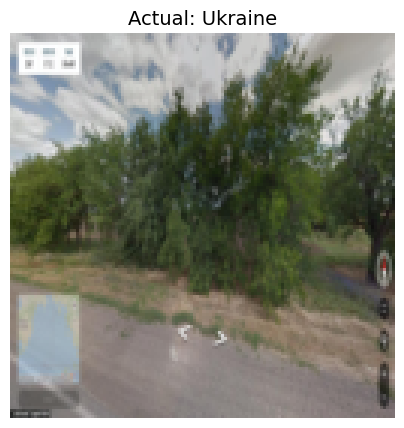

Predictions:
  1: Brazil (20.68%)
  2: United States (20.57%)
  3: Thailand (9.21%)
  4: France (3.94%)


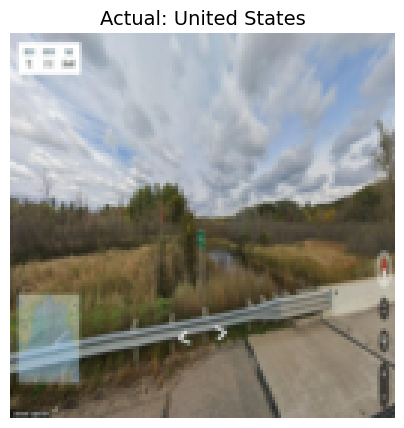

Predictions:
  1: France (17.26%)
  2: United States (11.54%)
  3: United Kingdom (11.21%)
  4: Japan (8.83%)


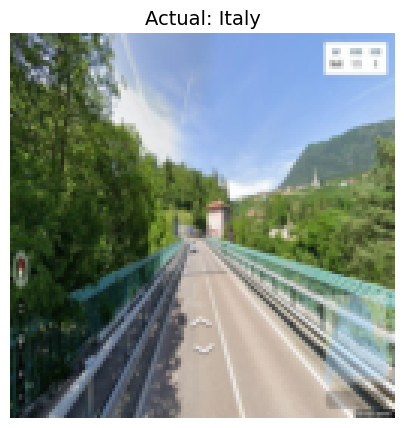

Predictions:
  1: United States (35.59%)
  2: Singapore (16.69%)
  3: France (11.45%)
  4: Brazil (5.97%)


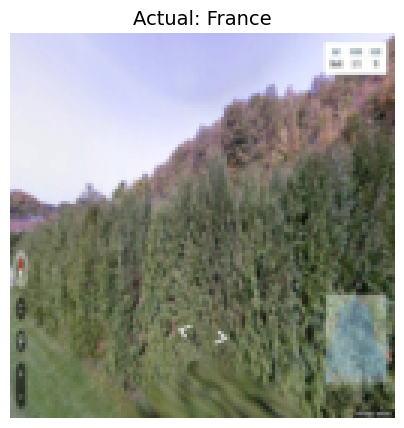

Testing:   1%|█▉                                                                                                                                                                                                                                     | 1/118 [00:16<31:12, 16.00s/it]

Predictions:
  1: France (9.27%)
  2: United Kingdom (8.58%)
  3: United States (5.50%)
  4: Spain (5.46%)


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.87it/s]


Classification Report:
                          precision    recall  f1-score   support

                   Aland       0.00      0.00      0.00         1
                 Albania       0.00      0.00      0.00         6
               Argentina       1.00      0.02      0.04       102
               Australia       0.57      0.06      0.11       260
                 Austria       0.00      0.00      0.00        50
              Bangladesh       0.00      0.00      0.00        16
                 Belarus       0.00      0.00      0.00         1
                 Belgium       0.00      0.00      0.00        39
                  Bhutan       0.00      0.00      0.00         4
                 Bolivia       0.00      0.00      0.00        14
                Botswana       0.20      0.05      0.08        21
                  Brazil       0.21      0.24      0.23       352
                Bulgaria       1.00      0.03      0.05        37
                Cambodia       0.00      0.00      0

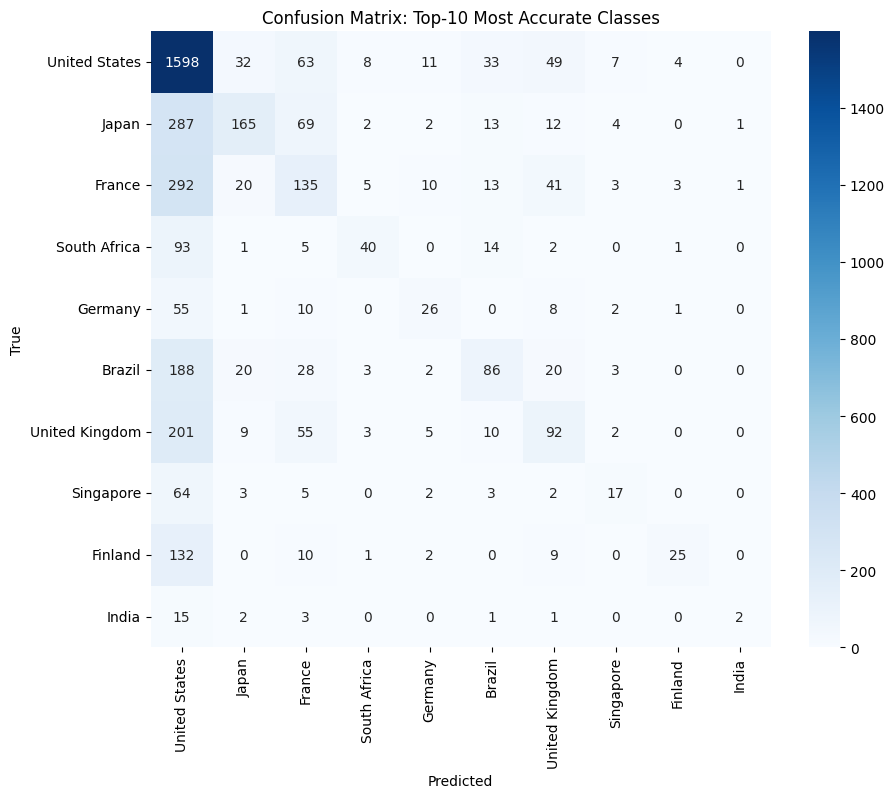

Testing EfficientNet_B0...
Testing model...


Testing:   0%|                                                                                                                                                                                                                                               | 0/118 [00:00<?, ?it/s]

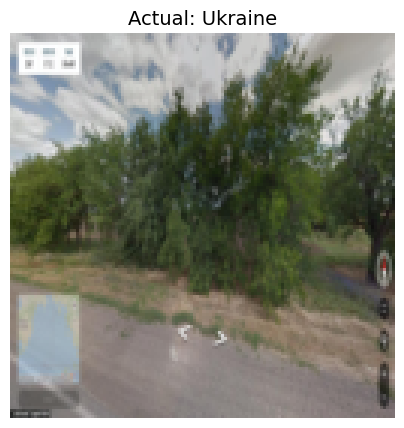

Predictions:
  1: Ghana (20.37%)
  2: Brazil (19.30%)
  3: Thailand (14.10%)
  4: United States (10.40%)


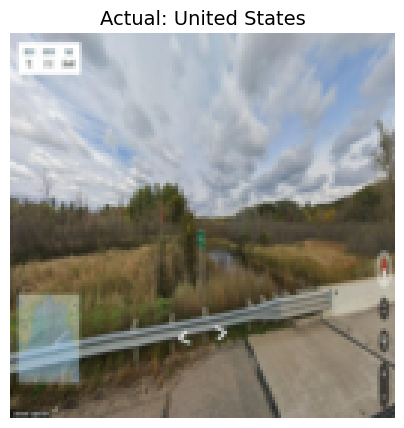

Predictions:
  1: New Zealand (65.21%)
  2: Australia (10.34%)
  3: United States (7.62%)
  4: France (5.30%)


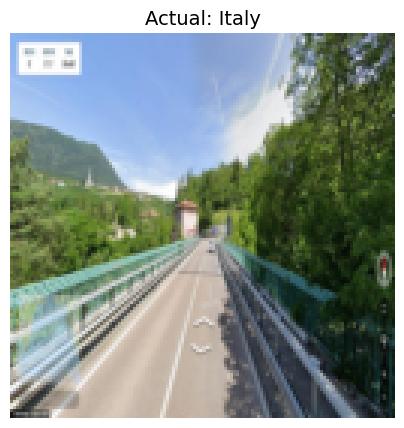

Predictions:
  1: France (26.07%)
  2: Italy (23.99%)
  3: Japan (23.76%)
  4: Austria (9.67%)


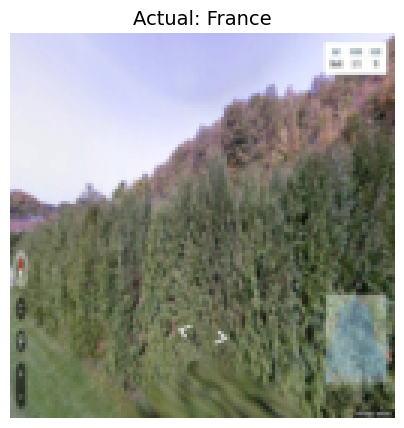

Testing:   1%|█▉                                                                                                                                                                                                                                     | 1/118 [00:14<29:11, 14.97s/it]

Predictions:
  1: Italy (53.03%)
  2: United Kingdom (21.71%)
  3: France (13.18%)
  4: Ireland (6.24%)


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:03<00:00,  1.85it/s]
C:\Users\okroe\AppData\Local\Temp\ipykernel_12148\2817373227.py:46: RuntimeWarning: invalid value encountered in divide
  class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100  # Accuracy per class in percentage


Classification Report:
                          precision    recall  f1-score   support

                   Aland       0.00      0.00      0.00         1
                 Albania       0.00      0.00      0.00         6
          American Samoa       0.00      0.00      0.00         0
                 Andorra       0.00      0.00      0.00         0
               Argentina       0.44      0.69      0.54       102
               Australia       0.61      0.57      0.59       260
                 Austria       0.35      0.38      0.36        50
              Bangladesh       0.25      0.12      0.17        16
                 Belarus       0.00      0.00      0.00         1
                 Belgium       0.00      0.00      0.00        39
                  Bhutan       0.00      0.00      0.00         4
                 Bolivia       0.45      0.36      0.40        14
                Botswana       0.46      0.62      0.53        21
                  Brazil       0.62      0.54      0

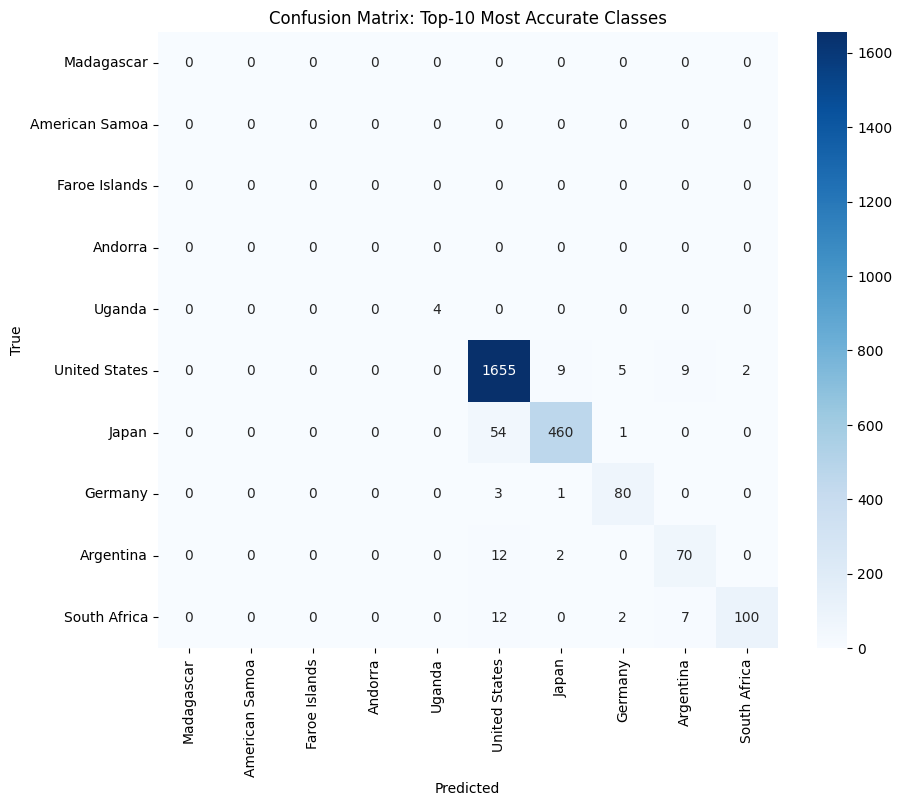

In [9]:
# Train and validate models
print("Starting training...")
for epoch in range(EPOCHS):
    print(f"Training ResNet18 (Transfer Learning), Epoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(epoch, model_resnet18, optimizer_resnet18)
    val_loss, val_acc = validate(model_resnet18)
    print(f"ResNet18 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"ResNet18 - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    print(f"Training EfficientNet, Epoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(epoch, model_effnet, optimizer_effnet)
    val_loss, val_acc = validate(model_effnet)
    print(f"EfficientNet - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"EfficientNet - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

# Save models
def save_model_and_classes(model, class_names, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        "model_state_dict": model.state_dict(),
        "class_names": class_names,
    }, path)
    print(f"Model saved to {path}")

save_model_and_classes(model_resnet18, class_names, "models/resnet18.pth")
save_model_and_classes(model_effnet, class_names, "models/efficientnet_b0.pth")

# Test models
print("Testing ResNet18...")
test(model_resnet18)
print("Testing EfficientNet_B0...")
test(model_effnet)